# Exercise 4
In this exercise, we will control a 2D drone depicted in the figure below <br>
<img src='quadrotor.png' width="300">

Consider the following simplified linear model of the drone
$$\begin{align}
    x_{n+1} = A
    x_n + B u_n
\end{align}$$

where the components of the state $x_n$ correspond to the horizontal position and velocity of the quadrotor, its vertical position and velocity and its orientation and angular velocity. The control vector
$u_n$ contains the forces produced by the rotors (our control inputs).
The module ```quadrotor.py``` defines the matrices $A$ and $B$ and code to generate a simulation of the drone.

In [1]:
## what we need to do computation and display the drone
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
# from scipy.linalg import block_diag
import quadrotor

In [2]:
# we define a few constants
xdim = 6 # dimension of the state (p,v)
udim = 2 # dimension of the control (u)
N = 500 # number of steps
nvars = N*udim + (N+1)*xdim # total number of variables
dt = 0.01 #delta t
sdim = xdim + udim # dimension of total state vector
## We define the cost
Q = np.eye(xdim)
Q[0,0] = Q[2,2] = Q[4,4] = 10.  # position penalty
Q[1,1] = Q[3,3] = Q[5,5] = 5.   # velocity penalty
R = np.eye(udim) * 0.01
des_state = np.array([3,0,3,0,0,0,0,0]).reshape(-1,1)


## we create G
def get_cost_matrix_G(Q, R):
    G = np.zeros((nvars, nvars))
    G[-xdim:, -xdim:] = Q
    mini_G = np.block([[Q, np.zeros((xdim, udim))], [np.zeros((udim, xdim)), R]])
    # Fill G blocks
    for i in np.arange(0, (xdim + udim)*N, (xdim+udim)):
        G[i:i+8, i:i+8] = mini_G
    return G

G = get_cost_matrix_G(Q,R)
print(G.shape)

(4006, 4006)


In [3]:
##### CREATE THE KKT SYSTEM #####
## create the linear equality constraint
M = np.zeros([xdim * (N+1), nvars])
d = np.zeros([xdim * (N+1)])
mini_M = np.block([[-np.eye(xdim), np.zeros((xdim, udim))], [quadrotor.A, quadrotor.B]])  # Define mini_M correctly
j = 0
for i in np.arange(0, 8*N, 8):
    M[j:(j+12), i:(i+8)] = mini_M  # Assign the mini_M block to M
    j += 6  # Increment by 6 for the next block
M[0:6, 0:6] = np.identity(6)
M[-6:, -6:] = -np.identity(6)

print(M.shape)

# Define p and ydes vectors
p = np.zeros((6 * (N + 1), 1))
ydes = np.block([[np.kron(np.ones((N, 1)), des_state)], [des_state[0:6]]])

# Compute G_des
G_des = np.matmul(G, ydes)

# Create the KKT matrix
nconstraints = M.shape[0]
nvars = G.shape[1]  # Assuming G has `nvars` columns
KKT = np.zeros((nvars + nconstraints, nvars + nconstraints))

# Fill the KKT matrix with appropriate blocks
KKT[0:nvars, 0:nvars] = G
KKT[nvars:, 0:nvars] = M
KKT[0:nvars, nvars:] = M.T

# Define the right-hand side vector (f)
f = np.zeros((nvars + nconstraints, 1))
f[0:nvars] = G_des  # Top part of f (matching `G_des`)
f[nvars:, 0] = p.flatten()  # Bottom part of f (matching `p`)

# Solve the KKT system
yl = np.linalg.solve(KKT, f)

(3006, 4006)


In [4]:
x_pos = yl[0:N*8+6:8].flatten()
x_vel = yl[1:N*8+6:8].flatten()
y_pos = yl[2:N*8+6:8].flatten()
y_vel = yl[3:N*8+6:8].flatten()
angle = yl[4:N*8+6:8].flatten()
angle_vel = yl[5:N*8+6:8].flatten()
control1 = yl[6:N*8+6:8].flatten()
control2 = yl[7:N*8+6:8].flatten()

x0 = np.array([
    x_pos,      # Shape: (501,)
    x_vel,      # Shape: (501,)
    y_pos,      # Shape: (501,)
    y_vel,      # Shape: (501,)
    angle,      # Shape: (501,)
    angle_vel   # Shape: (501,)
])

# print(f"x0 shape: {x0.shape}")  # Should output: (6, 501)

u = np.vstack([
    control1.flatten(),
    control2.flatten()
])  # Shape: (2, 500)

u = np.hstack([u, np.zeros((2, 1))])  # Shape: (2, 501)

# plt.figure(figsize=[9,9])
# plt.subplot(3,2,1)
# plt.ylabel('Horizontal Position')
# plt.plot(x_pos, 'x')
# plt.subplot(3,2,2)
# plt.ylabel('Horizontal Velocity')
# plt.plot(x_vel, 'x')
# plt.subplot(3,2,3)
# plt.ylabel('Vertical Position')
# plt.plot(y_pos, 'x')
# plt.subplot(3,2,4)
# plt.ylabel('Vertical Velocity')
# plt.plot(y_vel, 'x')
# plt.subplot(3,2,5)
# plt.ylabel('Orientation')
# plt.plot(angle, 'x')
# plt.subplot(3,2,6)
# plt.ylabel('Angular Velocity')
# plt.plot(angle_vel, 'x')

# plt.figure(figsize=[9,6])
# plt.subplot(2,1,1)
# plt.plot(control1, 'x')
# plt.ylabel('Control 1: Rotor Force 1')
# plt.subplot(2,1,2)
# plt.plot(control2, 'x')
# plt.ylabel('Control 2: Rotor Force 2')

# Optionally, animate the robot's movement (this requires the quadrotor animation function)
# quadrotor.animate_robot(x0, np.array([control1, control2]), goal=[3, 3])  

(4006, 4006)
(4006, 1)
(8012, 4006)
(8012, 1)
(3006, 4006)
(3006, 1)


Text(0, 0.5, 'Control 2: Rotor Force 2')

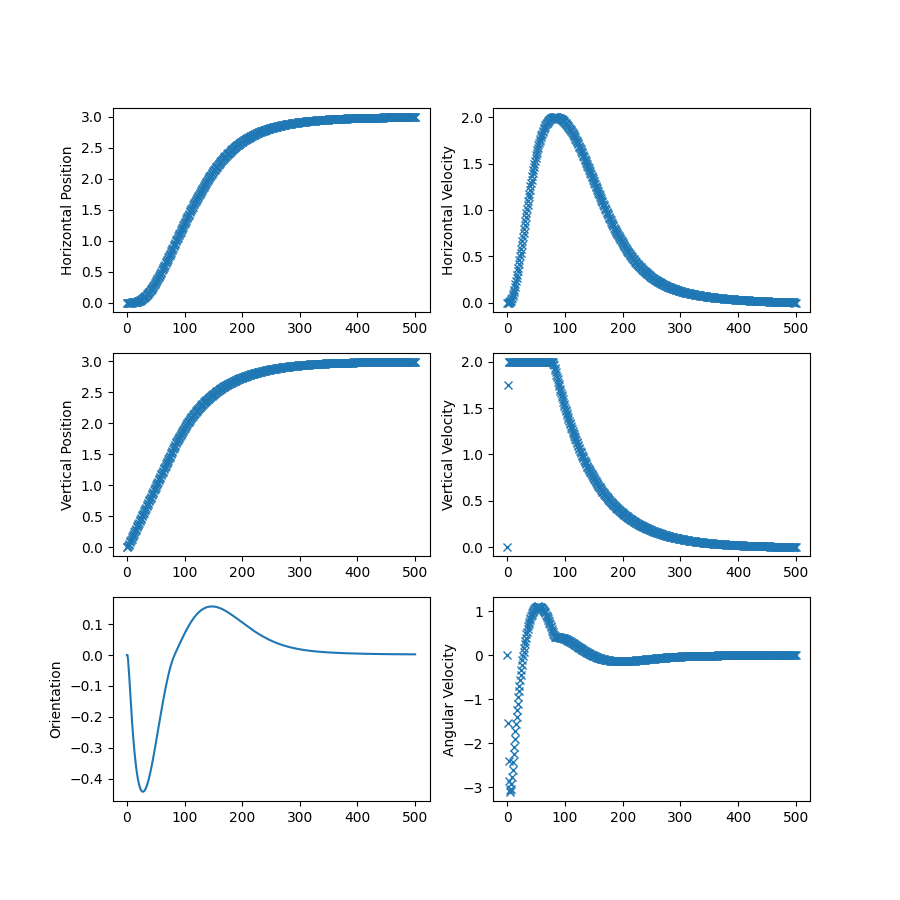

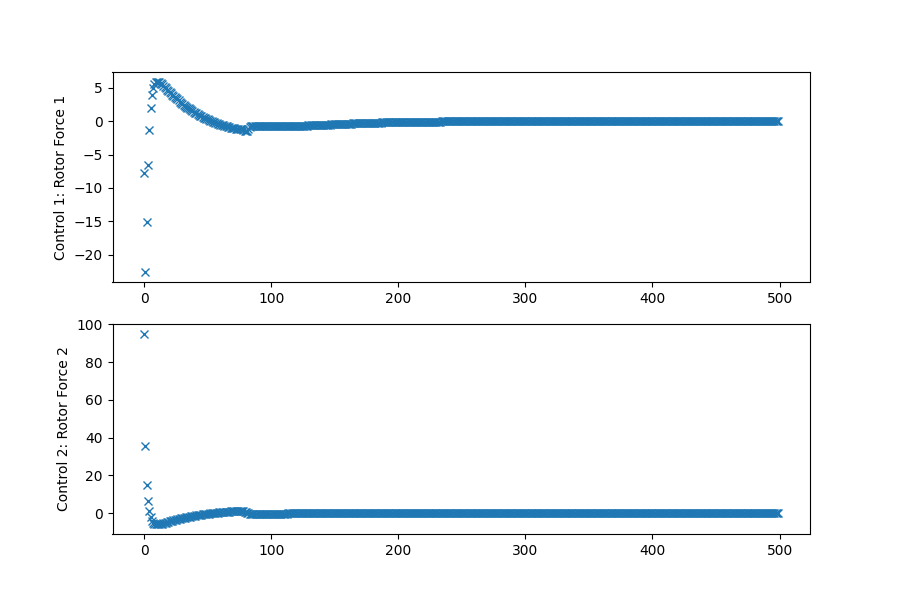

In [5]:
from qpsolvers import solve_qp
'''
H = np.zeros((nvars,nvars))
mini_H = np.zeros((8,8))
mini_H[1,1] = mini_H[3,3] = 1


H[-6:,-6:] = mini_H[0:6,0:6]
# Fill H blocks
for i in np.arange(0, (xdim + udim)*N, (xdim+udim)):
	H[i:i+8, i:i+8] = mini_H
# print(H[8:16,8:16])

max_lims = np.array([0, 2, 0, 2, 0, 0, 0, 0]).reshape(-1,1)

h = np.zeros((nvars,1))
h[-6:] = max_lims[0:6]
for i in np.arange(0, 8*N, 8):
	h[i:i+8] = max_lims
'''

max_lims = np.array([0, 2, 0, 2, 0, 0, 0, 0]).reshape(-1,1)
# For upper bounds 
H_upper = np.zeros((nvars, nvars))
mini_H = np.zeros((8, 8))
mini_H[1,1] = mini_H[3,3] = 1

H_upper[-6:, -6:] = mini_H[0:6, 0:6]
for i in np.arange(0, (xdim + udim) * N, (xdim + udim)):
    H_upper[i:i + 8, i:i + 8] = mini_H

h_upper = np.zeros((nvars, 1))
h_upper[-6:] = max_lims[0:6]
for i in np.arange(0, 8 * N, 8):
    h_upper[i:i + 8] = max_lims

# For lower bounds 
H_lower = np.zeros((nvars, nvars))
H_lower[-6:, -6:] = -mini_H[0:6, 0:6]
for i in np.arange(0, (xdim + udim) * N, (xdim + udim)):
    H_lower[i:i + 8, i:i + 8] = -mini_H

h_lower = np.zeros((nvars, 1))
h_lower[-6:] = max_lims[0:6]
for i in np.arange(0, 8 * N, 8):
    h_lower[i:i + 8] = max_lims

# Now concatenate both upper and lower bounds to form the full constraint vector
H = np.vstack((H_upper, H_lower))
h = np.vstack((h_upper, h_lower))

## Sanity Check for shapes
print(G.shape)
print(G_des.shape)
print(H.shape)
print(h.shape)
print(M.shape)
# p = np.vstack((p, np.zeros((6,1)).reshape(-1,1)))
print(p.shape)
res = solve_qp(G, -G_des, H, h, M, p, solver='cvxopt')

# # Extract the state values (x) from the solution vector, reshape them, and transpose to shape (6, 500)
# x2 = res[:4000].reshape(-1, 8)[:, :6].T

# # Extract the control values (u) from the solution vector, reshape them, and transpose to shape (2, 500)
# u2 = res[:4000].reshape(-1, 8)[:, 6:].T

# # Print the final state of the system (last time step) with rounded values for clarity
# print(f"\n\nFinal State = {np.round(x2[:, N-1], 5)}")

# # Print the maximum and minimum values of the first control input (u1)
# print(f"U1 : Max = {round(u2[0].max(), 6)}, Min = {round(u2[0].min(), 5)}")

# # Print the maximum and minimum values of the second control input (u2)
# print(f"U2 : Max = {round(u2[1].max(), 7)}, Min = {round(u2[1].min(), 5)}")

x_pos = res[0:N*8+6:8].flatten()
x_vel = res[1:N*8+6:8].flatten()
y_pos = res[2:N*8+6:8].flatten()
y_vel = res[3:N*8+6:8].flatten()
angle = res[4:N*8+6:8].flatten()
angle_vel = res[5:N*8+6:8].flatten()
control1 = res[6:N*8+6:8].flatten()
control2 = res[7:N*8+6:8].flatten()

plt.figure(figsize=[9,9])
plt.subplot(3,2,1)
plt.ylabel('Horizontal Position')
plt.plot(x_pos, 'x')
plt.subplot(3,2,2)
plt.ylabel('Horizontal Velocity')
plt.plot(x_vel, 'x')
plt.subplot(3,2,3)
plt.ylabel('Vertical Position')
plt.plot(y_pos, 'x')
plt.subplot(3,2,4)
plt.ylabel('Vertical Velocity')
plt.plot(y_vel, 'x')
plt.subplot(3,2,5)
plt.ylabel('Orientation')
plt.plot(angle)
plt.subplot(3,2,6)
plt.ylabel('Angular Velocity')
plt.plot(angle_vel, 'x')

plt.figure(figsize=[9,6])
plt.subplot(2,1,1)
plt.plot(control1, 'x')
plt.ylabel('Control 1: Rotor Force 1')
plt.subplot(2,1,2)
plt.plot(control2, 'x')
plt.ylabel('Control 2: Rotor Force 2')

# Animate the quadrotor using the computed state (x2) and control inputs (u2) with the desired goal position
# quadrotor.animate_robot(x2, u2, goal=[3, 3])

In [6]:
# Print the final state of the system (last time step) with rounded values for clarity
print(f"\n\nFinal State = {np.round(x2[:, N-1], 5)}")

# Print the maximum and minimum values of the first control input (u1)
print(f"U1 : Max = {round(u2[0].max(), 6)}, Min = {round(u2[0].min(), 5)}")

# Print the maximum and minimum values of the second control input (u2)
print(f"U2 : Max = {round(u2[1].max(), 7)}, Min = {round(u2[1].min(), 5)}")

NameError: name 'x2' is not defined